In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import eleanor
import lightkurve as lk

star = eleanor.Source(tic=91961, sector='recent')
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=False, do_pca=True, regressors='corner')
plt.figure(figsize=(15, 5))
q = data.quality == 0

No eleanor postcard has been made for your target (yet). Using TessCut instead.


<Figure size 1500x500 with 0 Axes>

In [2]:
lk = data.to_lightkurve().normalize()
period = np.linspace(1, 10, 10000)
bls = lk.to_periodogram(method='bls', period=period, frequency_factor=500)

period = bls.period_at_max_power.value * 2
t0 = bls.transit_time_at_max_power.value
duration = bls.duration_at_max_power

period, t0, duration

(5.283528352835283, 2334.4799011186674, <Quantity 0.05 d>)

<AxesSubplot: xlabel='Period [$\\mathrm{d}$]', ylabel='BLS Power'>

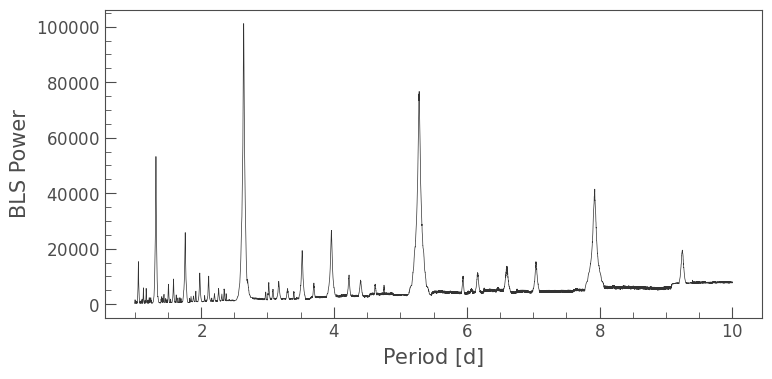

In [3]:
bls.plot()

In [4]:
from transitleastsquares import transitleastsquares
model = transitleastsquares(lk.time.value, lk.flux.value)
results = model.power(period_min=2.0, period_max=10.0)

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 36 durations
Searching 3642 data points, 1034 periods from 2.0 to 9.981 days
Using all 16 CPU threads


100%|██████████| 1034/1034 periods | 00:10<00:00


Searching for best T0 for period 2.63968 days


(0.0, 9.980855699144197)

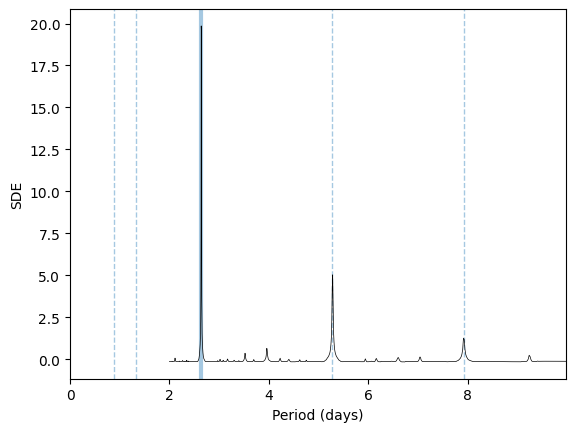

In [5]:
plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 4):
    ax.axvline(n * results.period, alpha=0.4, lw=1, linestyle='dashed')
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle='dashed')
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

(0.4, 0.6)

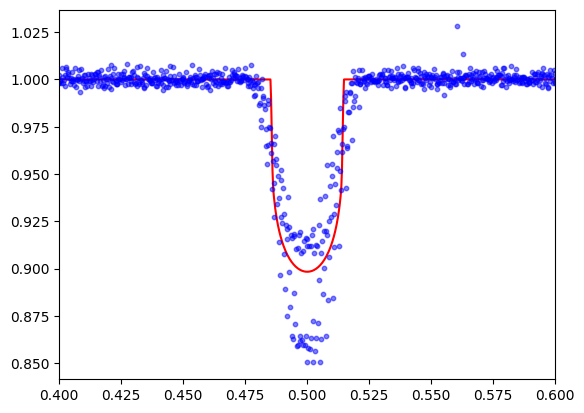

In [6]:
plt.figure()
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red'
)
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2
)
plt.xlim(0.4, 0.6)

<AxesSubplot: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

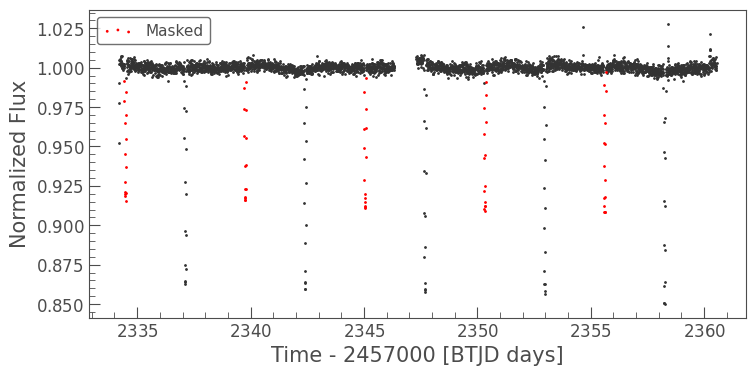

In [7]:
mask = bls.get_transit_mask(period=period, transit_time=t0, duration=duration*2)
masked_lk = lk[~mask]
ax = masked_lk.scatter()
lk[mask].scatter(ax=ax, c='r', label='Masked')

Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 167 durations
Searching 3571 data points, 1723 periods from 2.001 to 9.993 days
Using all 16 CPU threads


100%|██████████| 1723/1723 periods | 00:18<00:00


Searching for best T0 for period 2.64177 days


C:\Users\Andy Teng\.conda\envs\lc_testing\lib\site-packages\transitleastsquares\main.py:411: UserWarning: 5 of 10 transits without data. The true period may be twice the given period.
  warnings.warn(text)


(0.4, 0.6)

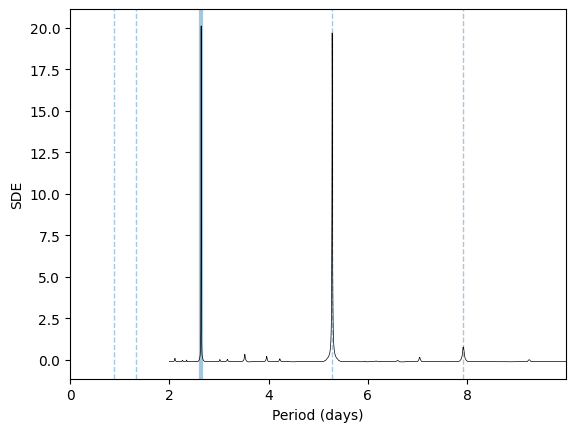

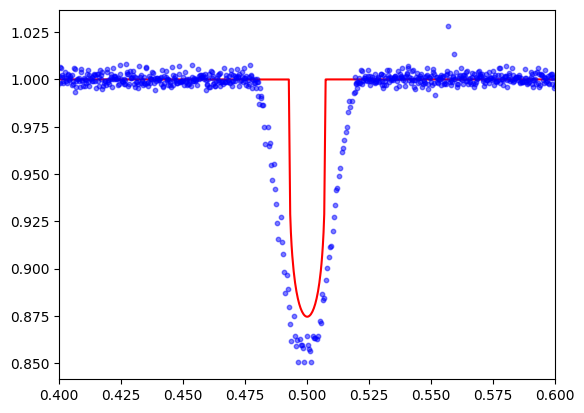

In [8]:
masked_model = transitleastsquares(masked_lk.time.value, masked_lk.flux.value)
results = masked_model.power(oversampling_factor=5, duration_grid_step=1.02, period_min=2.0, period_max=10.0)

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 4):
    ax.axvline(n * results.period, alpha=0.4, lw=1, linestyle='dashed')
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle='dashed')
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

plt.figure()
plt.plot(
    results.model_folded_phase,
    results.model_folded_model,
    color='red'
)
plt.scatter(
    results.folded_phase,
    results.folded_y,
    color='blue',
    s=10,
    alpha=0.5,
    zorder=2
)
plt.xlim(0.4, 0.6)